In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, LinearConstraint

# Convex problem

In [3]:
A_rotation = np.array([[1, 0.3],
                  [0.3, 0.7]])

In [4]:
def obj_func(x, A=A_rotation):
    
    xt = x.dot(A)
    
    return (xt[0] - 0.5) ** 2 + (xt[1] - 2) ** 2

constraint = LinearConstraint(np.array([[2., 1.]]), -1.0, np.inf)

In [5]:
true_optimum = np.array([0.5, 2]).dot(np.linalg.inv(A_rotation))

In [6]:
x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.vstack((X1.flatten().reshape([1, -1]), X2.flatten().reshape([1, -1])))
F = np.array([obj_func(x) for x in X.T])
F = F.reshape([100, 100])

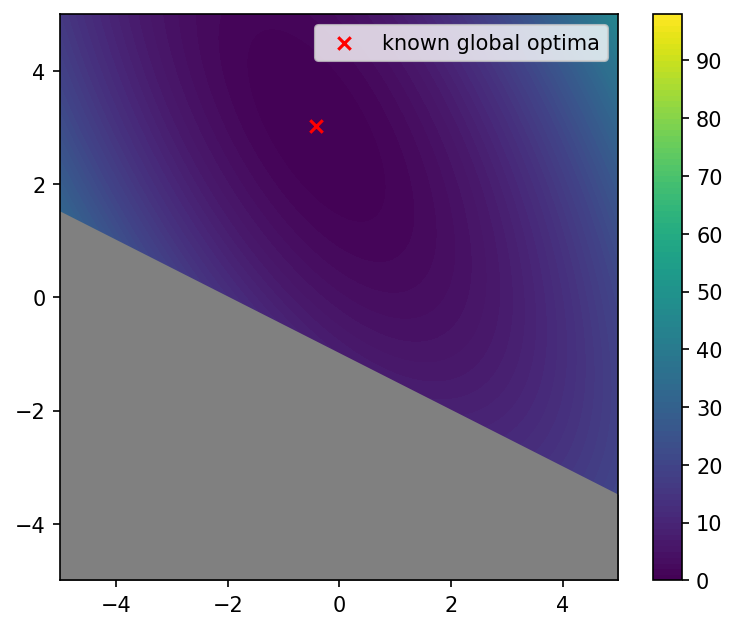

In [7]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, F, levels=100)
fig.colorbar(surf, shrink=1.0, aspect=20)

ax.fill_between(x1, -5, -0.5 * x1 - 1, color="grey")
ax.scatter([-0.40983607],  [3.03278689], marker="x", color="red", label="known global optima")
ax.legend()

plt.show()

In [8]:
sol_slsqp = minimize(obj_func, [2.5, 0.0], constraints=constraint, method="SLSQP")
print(sol_slsqp)

     fun: 9.515423663381185e-17
     jac: array([-3.62009113e-09, -3.17585562e-09])
 message: 'Optimization terminated successfully'
    nfev: 13
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([-0.40983607,  3.03278688])


In [9]:
sol_de = differential_evolution(obj_func, bounds=[(-5., 5.), (-5., 5.)], constraints=constraint,
                                popsize=50, strategy="rand1bin", mutation=(0.05, 1.0), recombination=0.7,
                                tol=1e-16, maxiter=200, updating="deferred")

print(sol_de)

           constr: [array([0.])]
 constr_violation: 0.0
              fun: 1.232595164407831e-32
            maxcv: 0.0
          message: 'Optimization terminated successfully.'
             nfev: 18543
              nit: 186
          success: True
                x: array([-0.40983607,  3.03278689])


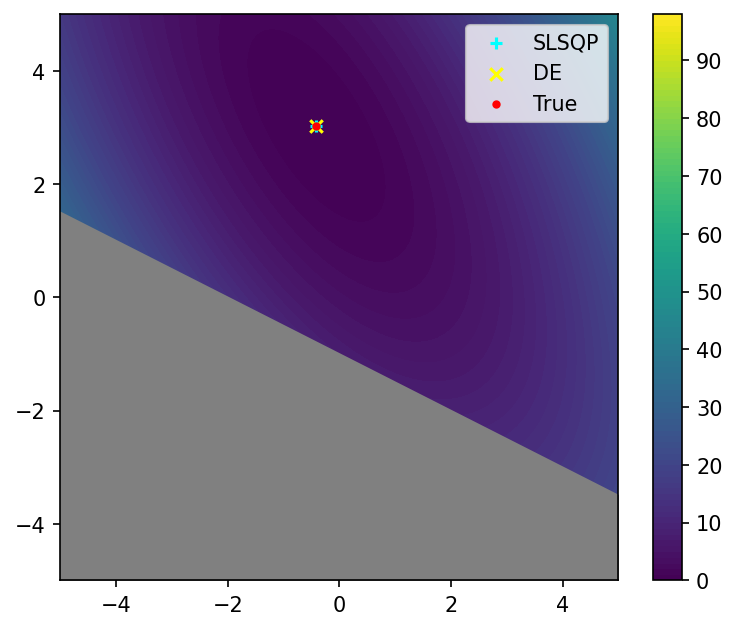

In [10]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, F, levels=100)
fig.colorbar(surf, shrink=1.0, aspect=20)

ax.scatter([sol_slsqp.x[0]],  [sol_slsqp.x[1]], marker="+", color="cyan", label="SLSQP")
ax.scatter([sol_de.x[0]],  [sol_de.x[1]], marker="x", color="yellow", label="DE")
ax.scatter([-0.40983607],  [3.03278689], marker=".", color="red", label="True")
ax.fill_between(x1, -5, -0.5 * x1 - 1, color="grey")
ax.legend()

plt.show()

# Nonconvex

In [11]:
def obj_func_ncvx(x):
    
    A = np.array([[1, 0.3],
                  [0.3, 0.7]])
    
    xt = x.dot(A)
    
    rugosity_1 = (xt[0] * np.sin(15 * xt[0]) - 0.5) ** 2 + (xt[1] * np.sin(15 * xt[1]) - 2) ** 2
    rugosity_2 = np.sin(15 * x[0]) ** 2 + np.sin(25 * x[1]) ** 2
    convex = (xt[0] - 0.5) ** 2 + (xt[1] - 2) ** 2
    
    return 5 * rugosity_2 + rugosity_1 + convex

In [12]:
n_mesh = 300
x1 = np.linspace(-5, 5, n_mesh)
x2 = np.linspace(-5, 5, n_mesh)
X1, X2 = np.meshgrid(x1, x2)
X = np.vstack((X1.flatten().reshape([1, -1]), X2.flatten().reshape([1, -1])))
F = np.array([obj_func_ncvx(x) for x in X.T])
F = F.reshape([n_mesh, n_mesh])

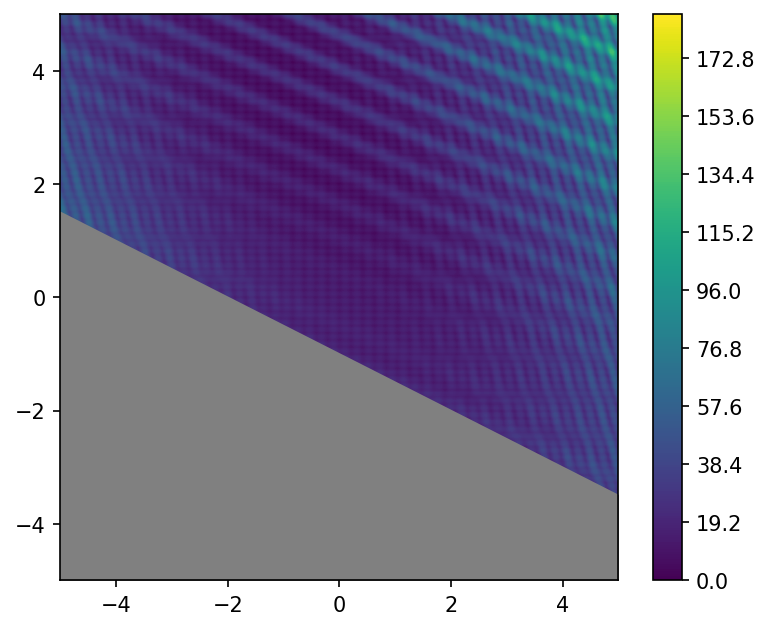

In [13]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, F, levels=n_mesh)
fig.colorbar(surf, shrink=1.0, aspect=20)

ax.fill_between(x1, -5, -0.5 * x1 - 1, color="grey")
#ax.legend()

plt.show()

In [14]:
sol_slsqp = minimize(obj_func_ncvx, [2.5, 0.0], constraints=constraint, method="SLSQP")
print(sol_slsqp)

     fun: 13.067048687935284
     jac: array([-0.00733304, -0.00806332])
 message: 'Optimization terminated successfully'
    nfev: 29
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([2.52062202, 0.00275179])


In [15]:
%%time
sol_de = differential_evolution(obj_func_ncvx, bounds=[(-5., 5.), (-5., 5.)], constraints=constraint,
                                popsize=50, strategy="rand1bin", mutation=(0.05, 1.0), recombination=0.7,
                                tol=1e-16, maxiter=200, updating="deferred")

print(sol_de)

           constr: [array([0.])]
 constr_violation: 0.0
              fun: 0.05943295487717755
            maxcv: 0.0
          message: 'Maximum number of iterations has been exceeded.'
             nfev: 19593
              nit: 200
          success: False
                x: array([-0.41828732,  3.26786472])
Wall time: 2.23 s


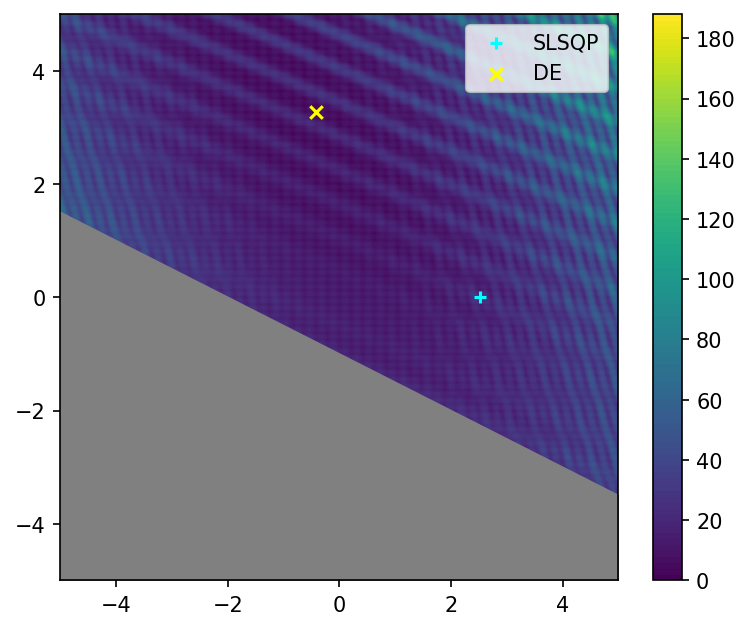

In [16]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, F, levels=100)
fig.colorbar(surf, shrink=1.0, aspect=20)

ax.scatter([sol_slsqp.x[0]],  [sol_slsqp.x[1]], marker="+", color="cyan", label="SLSQP")
ax.scatter([sol_de.x[0]],  [sol_de.x[1]], marker="x", color="yellow", label="DE")
ax.fill_between(x1, -5, -0.5 * x1 - 1, color="grey")
ax.legend()

plt.show()

In [17]:
np.random.seed(1)
X1_guess = -5 + 10 * np.random.random(500)
X2_guess = -5 + 10 * np.random.random(500)

In [18]:
%%time
fopt = np.inf
xopt = np.array([np.nan, np.nan])

for i in range(500):
    sol_scipy_i = minimize(obj_func_ncvx, [X1_guess[i], X2_guess[i]], constraints=constraint, method="SLSQP")

    if sol_scipy_i.success:
        if sol_scipy_i.fun < fopt:
            fopt = sol_scipy_i.fun
            xopt = sol_scipy_i.x

Wall time: 3.51 s


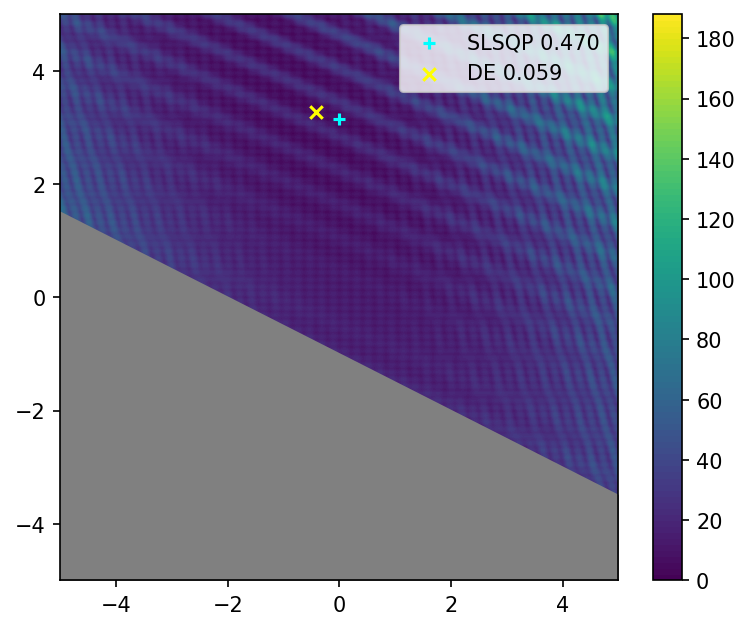

In [19]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, F, levels=100)
fig.colorbar(surf, shrink=1.0, aspect=20)

ax.scatter([xopt[0]],  [xopt[1]], marker="+", color="cyan", label=f"SLSQP {fopt:.3f}")
ax.scatter([sol_de.x[0]],  [sol_de.x[1]], marker="x", color="yellow", label=f"DE {sol_de.fun:.3f}")
ax.fill_between(x1, -5, -0.5 * x1 - 1, color="grey")
ax.legend()

plt.show()